# Imports

In [ ]:
!pip install colorama

In [2]:
import os
import math
import json
import random as rnd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from colorama import Fore, Back, Style
from matplotlib.ticker import NullFormatter


DEVICE = torch.device('cuda')

In [ ]:
!nvidia-smi

# Build MC-Dominoes dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/cifar-10-python.tar.gz to ./data/FashionMNIST/
Train length: 6991
Test length: 1980
Test length randomized mnist: 1980
Test length randomized cifar10: 1980
Non-randomized train dataset:


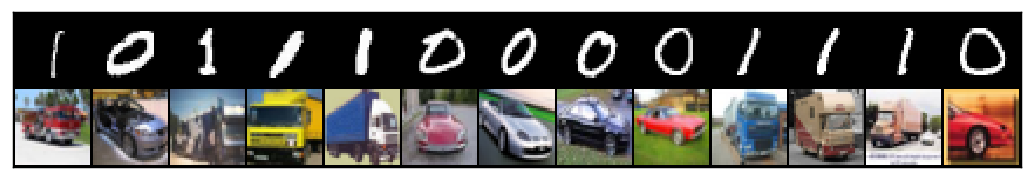

Non-randomized test dataset:


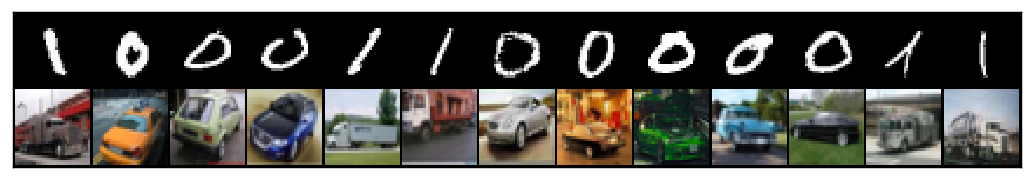

MNIST-randomized test dataset:


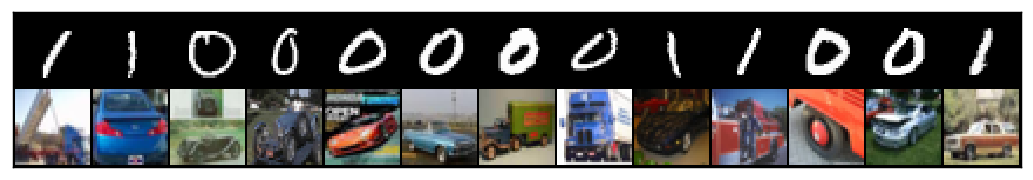

CIFAR10-randomized test dataset:


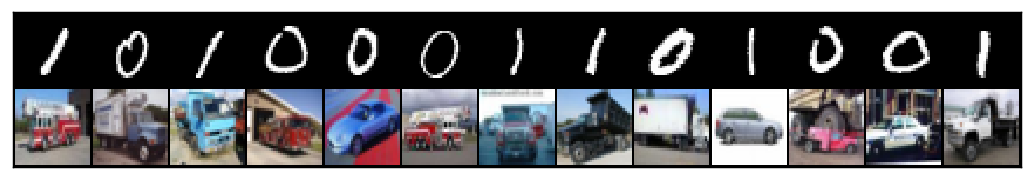

In [4]:
def plot_samples(dataset, nrow=13, figsize=(10,7)):
  try:
    X, Y = dataset.tensors
  except:
    try:
      (X,) = dataset.tensors
    except:
      X = dataset
  fig = plt.figure(figsize=figsize, dpi=130)
  grid_img = vision_utils.make_grid(X[:nrow].cpu(), nrow=nrow, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter()) 
  _ = ax.yaxis.set_major_formatter(NullFormatter()) 
  plt.show()


def keep_only_lbls(dataset, lbls):
  lbls = {lbl: i for i, lbl in enumerate(lbls)}
  final_X, final_Y = [], []
  for x, y in dataset:
    if y in lbls:
      final_X.append(x)
      final_Y.append(lbls[y])
  X = torch.stack(final_X)
  Y = torch.tensor(final_Y).float().view(-1,1)
  return X, Y


def format_mnist(imgs):
  imgs = np.stack([np.pad(imgs[i][0], 2, constant_values=0)[None,:] for i in range(len(imgs))])
  imgs = np.repeat(imgs, 3, axis=1)
  return torch.tensor(imgs)


def build_mc_dataset(mnist_data, cifar_data, randomize_m=False, randomize_c=False):
  X_m_train_0, _ = keep_only_lbls(mnist_data, lbls=[0])
  X_m_train_1, _ = keep_only_lbls(mnist_data, lbls=[1])
  X_m_train_0 = format_mnist(X_m_train_0.view(-1, 1, 28, 28))
  X_m_train_1 = format_mnist(X_m_train_1.view(-1, 1, 28, 28))
  X_m_train_0 = X_m_train_0[torch.randperm(len(X_m_train_0))]
  X_m_train_1 = X_m_train_1[torch.randperm(len(X_m_train_1))]

  X_c_train_1, _ = keep_only_lbls(cifar_data, lbls=[1])
  X_c_train_9, _ = keep_only_lbls(cifar_data, lbls=[9])
  X_c_train_1 = X_c_train_1[torch.randperm(len(X_c_train_1))]
  X_c_train_9 = X_c_train_9[torch.randperm(len(X_c_train_9))]

  min_01 = min(len(X_m_train_0), len(X_c_train_1))
  min_19 = min(len(X_m_train_1), len(X_c_train_9))
  X_top = torch.cat((X_m_train_0[:min_01], X_m_train_1[:min_19]),dim=0) 
  X_bottom = torch.cat((X_c_train_1[:min_01], X_c_train_9[:min_19]),dim=0) 
  if randomize_m:
    shuffle = torch.randperm(len(X_top))
    X_top = X_top[shuffle]
  if randomize_c:
    shuffle = torch.randperm(len(X_bottom))
    X_bottom = X_bottom[shuffle]
  X_train = torch.cat((X_top, X_bottom), dim=2)
  Y_train = torch.cat((torch.zeros((min_01,)), torch.ones((min_19,))))
  shuffle = torch.randperm(len(X_train))
  X_train = X_train[shuffle]
  Y_train = Y_train[shuffle].float().view(-1,1)
  data_train = torch.utils.data.TensorDataset(X_train.to(DEVICE), Y_train.to(DEVICE))
  return data_train


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST('./data/mnist/', train=True, download=True, transform=transform)
cifar_train = torchvision.datasets.CIFAR10('./data/cifar10/', train=True, download=True, transform=transform)
mnist_perturb_base, mnist_train, mnist_valid = random_split(mnist_train, [10000, 45000, 5000], generator=torch.Generator().manual_seed(42))
cifar_perturb_base, cifar_train, cifar_valid = random_split(cifar_train, [10000, 35000, 5000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/mnist/', train=False, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10('./data/FashionMNIST/', train=False, download=True, transform=transform)


# Training / valid / test datasets
data_train = build_mc_dataset(mnist_train, cifar_train)
data_valid = build_mc_dataset(mnist_valid, cifar_valid)
data_test = build_mc_dataset(mnist_test, cifar_test)

train_dl = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)
valid_dl = torch.utils.data.DataLoader(data_valid, batch_size=1024, shuffle=False)
test_dl = torch.utils.data.DataLoader(data_test, batch_size=1024, shuffle=False)


# MNIST randomized test / valid datasets
data_test_rm = build_mc_dataset(mnist_test, cifar_test, randomize_m=True, randomize_c=False)
data_valid_rm = build_mc_dataset(mnist_valid, cifar_valid, randomize_m=True, randomize_c=False)

test_rm_dl = torch.utils.data.DataLoader(data_test_rm, batch_size=1024, shuffle=False)
valid_rm_dl = torch.utils.data.DataLoader(data_valid_rm, batch_size=1024, shuffle=False)

# F-MNIST randomized test / valid datasets
data_test_rc = build_mc_dataset(mnist_test, cifar_test, randomize_m=False, randomize_c=True)
data_valid_rc = build_mc_dataset(mnist_valid, cifar_valid, randomize_m=False, randomize_c=True)

test_rc_dl = torch.utils.data.DataLoader(data_test_rc, batch_size=1024, shuffle=False)
valid_rc_dl = torch.utils.data.DataLoader(data_valid_rc, batch_size=1024, shuffle=False)

print(f"Train length: {len(train_dl.dataset)}")
print(f"Test length: {len(test_dl.dataset)}")
print(f"Test length randomized mnist: {len(test_rm_dl.dataset)}")
print(f"Test length randomized cifar10: {len(test_rc_dl.dataset)}")

print("Non-randomized train dataset:")
plot_samples(data_train)

print("Non-randomized test dataset:")
plot_samples(data_test)

print("MNIST-randomized test dataset:")
plot_samples(data_test_rm)

print("CIFAR10-randomized test dataset:")
plot_samples(data_test_rc)

# Utils

In [5]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    acc.append((torch.sigmoid(model(X)) > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


@torch.no_grad()
def get_ens_acc(ensemble, dl):
  for model in ensemble:
    model.eval()
  acc = []
  for X, y in dl:
    probs = [torch.sigmoid(model(X)) for model in ensemble]
    probs = torch.stack(probs).mean(dim=0)
    acc.append((probs > 0.5) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  for model in ensemble:
    model.train()
  return acc.item()


def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample


def print_stats(stats):

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(16,3), dpi=110)
  ax1.grid()
  ax2.grid()
  ax3.grid()
  ax4.grid()
  ax5.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Adv Loss")
  ax3.set_title("Acc")
  ax4.set_title("Randomized MNIST Acc")
  ax5.set_title("Randomized CIFAR Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")
  ax3.set_xlabel("iterations")
  ax4.set_xlabel("iterations")
  ax5.set_xlabel("iterations")

  for m_id, m_stats in stats.items():
    if m_id[0] != 'm':
      continue
    itrs = [x[0] for x in m_stats['loss']]
    ax1.plot(itrs, [x[1] for x in m_stats['loss']], label=m_id)
    ax2.plot(itrs, [x[1] for x in m_stats['adv-loss']], label=m_id)
    ax3.plot(itrs, [x[1] for x in m_stats['acc']], label=m_id)
    ax4.plot(itrs, [x[1] for x in m_stats['rm-acc']], label=m_id)
    ax5.plot(itrs, [x[1] for x in m_stats['rc-acc']], label=m_id)

  ax3.set_ylim(0.45, 1.05)
  ax4.set_ylim(0.45, 1.05)
  ax5.set_ylim(0.45, 1.05)

# Model

In [7]:
class LeNet(nn.Module):

    def __init__(self, num_classes=10, dropout_p=0.0) -> None:
        super().__init__()
        self.droput_p = dropout_p
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 56, kernel_size=5)
        self.fc1 = nn.Linear(2016, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.avgpool_2 = nn.AvgPool2d(kernel_size=2)
        self.avgpool_3 = nn.AvgPool2d(kernel_size=3)

    def forward(self, x: torch.Tensor, dropout=True) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.avgpool_2(x)
        x = self.relu(self.conv2(x))
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.avgpool_3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, p=self.droput_p, training=dropout)
        x = self.fc3(x)
        return x

    
def set_train_mode(models):
  for m in models:
    m.train()


def set_eval_mode(models):
  for m in models:
    m.eval()

# Training code

In [8]:
def sequential_train(num_models, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl, 
                     test_rc_dl, perturb_dl, alpha=10, max_epoch=100, opt='SGD',
                     use_diversity_reg=True, reg_model_weights=None, lr_max=0.2, weight_decay=1e-5, use_scheduler=True):
  
  models = [LeNet(num_classes=1).to(DEVICE) for _ in range(num_models)]
  set_train_mode(models)
  
  stats = {f"m{i+1}": {"acc": [], "rm-acc": [], "rc-acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  if reg_model_weights is None:
    reg_model_weights = [1.0 for _ in range(num_models)]

  for m_idx, m in enumerate(models):

    if opt == 'SGD':
      opt = torch.optim.SGD(m.parameters(), lr=lr_max, momentum=0.9, weight_decay=weight_decay)
    else:
      opt = torch.optim.AdamW(m.parameters(), lr=lr_max, weight_decay=weight_decay)
    if use_scheduler:
      scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 0, lr_max, step_size_up=(len(train_dl)*max_epoch)//2, 
                                                    mode='triangular', cycle_momentum=False)
    else:
      scheduler = None
    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        (x_tilde,) = perturb_sampler()
        erm_loss = F.binary_cross_entropy_with_logits(m(x), y)
        
        if use_diversity_reg and m_idx != 0:
          adv_loss = []
          with torch.no_grad():
            set_eval_mode(models)
            ps = [torch.sigmoid(m_(x_tilde)) for m_ in models[:m_idx]]
            set_train_mode(models)
          psm = torch.sigmoid(m(x_tilde))
          for i in range(len(ps)):
            al = - ((1.-ps[i]) * psm + ps[i] * (1.-psm) + 1e-7).log().mean()
            adv_loss.append(al*reg_model_weights[i])
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/sum(reg_model_weights[:len(adv_loss)])
        loss = erm_loss + alpha * adv_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        if scheduler is not None: scheduler.step()

        if (itr + epoch * len(train_dl)) % 200 == 0:
          set_eval_mode(models)
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          if itr_ != 0 and scheduler is not None:
            print_str += f"[lr] {scheduler.get_last_lr()[0]:.5f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          acc_rm = get_acc(m, valid_rm_dl)
          acc_rc = get_acc(m, valid_rc_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          stats[f"m{m_idx+1}"]["rm-acc"].append((itr_, acc_rm))
          stats[f"m{m_idx+1}"]["rc-acc"].append((itr_, acc_rc))
          print_str += f" acc: {acc:.2f}, {Fore.BLUE} r0/1-acc: {acc_rm:.2f} {Style.RESET_ALL}"
          set_train_mode(models)
          print(print_str)
        
        itr += 1

    test_acc = get_acc(m, test_dl)
    test_rm_acc = get_acc(m, test_rm_dl)
    test_rc_acc = get_acc(m, test_rc_dl)
    ensemble_acc = get_ens_acc(models, test_rm_dl)
    stats[f"m{m_idx+1}"]["test-acc"] = test_acc
    stats[f"m{m_idx+1}"]["test-rm-acc"] = test_rm_acc
    stats[f"m{m_idx+1}"]["test-rc-acc"] = test_rc_acc
    stats[f"m{m_idx+1}"]["ens-test-rm-acc"] = ensemble_acc
    print(f"[m{m_idx+1}] [test] acc: {test_acc:.3f}, r-acc: {test_rm_acc:.3f}, r-acc-ens: {ensemble_acc:.3f}")

  return stats

# Experiments with $\mathcal{D}_\text{ood} = \mathcal{D}_\text{test}$

OOD dataset size: 1996
OOD dataset:


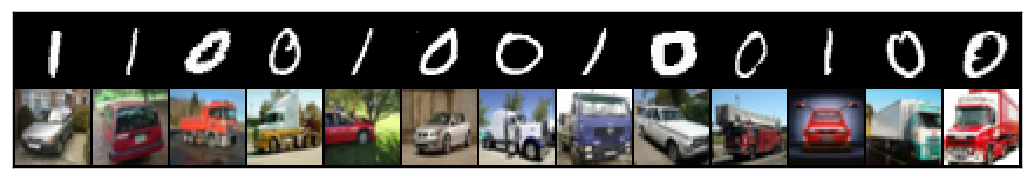

In [9]:
mnist_test = mnist_perturb_base
cifar_test = cifar_perturb_base

X_m_test, _ = keep_only_lbls(mnist_test, lbls=[0,1])
X_m_test = format_mnist(X_m_test.view(-1, 1, 28, 28))[torch.randperm(len(X_m_test))]

X_c_test, _ = keep_only_lbls(cifar_test, lbls=[1,9])
X_c_test = X_c_test[torch.randperm(len(X_c_test))]

min_l = min(len(X_m_test), len(X_c_test))
X_perturb = torch.cat((X_m_test[:min_l], X_c_test[:min_l]),  axis=2)

data_perturb = torch.utils.data.TensorDataset(X_perturb.to(DEVICE))

perturb_dl = torch.utils.data.DataLoader(data_perturb, batch_size=256, shuffle=True)

print(f"OOD dataset size: {len(perturb_dl.dataset)}")

print("OOD dataset:")
plot_samples(data_perturb)

In [ ]:
all_stats = []
for _ in range(5):
  stats = sequential_train(2, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl, test_rc_dl, 
                           perturb_dl, alpha=0.1, max_epoch=50, lr_max=0.001, use_scheduler=True)
  all_stats.append(stats)
  print_stats(stats)

# Experiments with $\mathcal{D}_\text{ood} \neq \mathcal{D}_\text{test}$

OOD dataset size: 8268
OOD dataset:


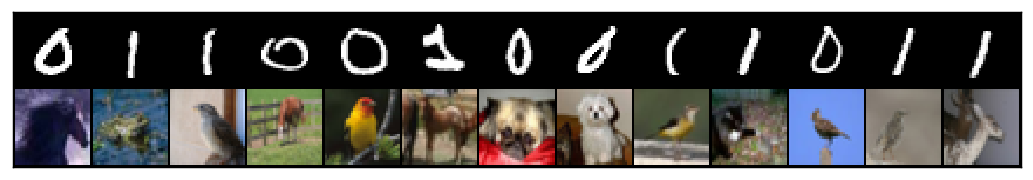

In [10]:
mnist_test = mnist_perturb_base
cifar_test = cifar_perturb_base

X_m_test_0, _ = keep_only_lbls(mnist_test, lbls=[0])
X_m_test_1, _ = keep_only_lbls(mnist_test, lbls=[1])
X_m_test_0 = format_mnist(X_m_test_0.view(-1, 1, 28, 28))[torch.randperm(len(X_m_test_0))]
X_m_test_1 = format_mnist(X_m_test_1.view(-1, 1, 28, 28))[torch.randperm(len(X_m_test_1))]

X_c_test_ood, _ = keep_only_lbls(cifar_test, lbls=[0,2,3,4,5,6,7,8])
X_c_test_ood = X_c_test_ood[torch.randperm(len(X_c_test_ood))]

K = int((len(X_c_test_ood) / len(X_m_test_0)) // 2)
X_m_test_0 = torch.cat([X_m_test_0 for _ in range(K)], dim=0)
X_m_test_1 = torch.cat([X_m_test_1 for _ in range(K)], dim=0)
X_perturb_0ood = torch.cat((X_m_test_0, X_c_test_ood[:len(X_m_test_0)]),  axis=2)
X_perturb_1ood = torch.cat((X_m_test_1, X_c_test_ood[-len(X_m_test_1):]),  axis=2)
X_perturb = torch.cat((X_perturb_0ood, X_perturb_1ood), dim=0)
X_perturb = X_perturb[torch.randperm(len(X_perturb))]

data_perturb = torch.utils.data.TensorDataset(X_perturb.to(DEVICE))

perturb_dl = torch.utils.data.DataLoader(data_perturb, batch_size=256, shuffle=True)

print(f"OOD dataset size: {len(perturb_dl.dataset)}")

print("OOD dataset:")
plot_samples(data_perturb)

In [ ]:
all_stats = []
for _ in range(5):
  stats = sequential_train(2, train_dl, valid_dl, valid_rm_dl, valid_rc_dl, test_dl, test_rm_dl, test_rc_dl, 
                           perturb_dl, alpha=1, max_epoch=50, lr_max=0.001, use_scheduler=True)
  all_stats.append(stats)
  print_stats(stats)